In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm

# SARIMA model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Seq2seq
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-12-26 02:02:43.389011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 02:02:43.390786: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 02:02:43.395633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 02:02:43.408481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735178563.429586    8187 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735178563.43

In [2]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Prédire février 2005 et mars 2005. Entraîner de février 2003 à janvien 2005
df = pd.concat([pd.read_parquet('data/tec_2003.parquet.gzip'), pd.read_parquet('data/tec_2004.parquet.gzip'), pd.read_parquet('data/tec_2005.parquet.gzip')])
df

,time,gdlat,glon,tec,datetime,year,month,day,hour,minute,second
3570,1.041379e+09,59.0,136.0,10.7,2003-01-01 00:02:30,2003,1,1,0,2,30
3571,1.041379e+09,59.0,137.0,10.6,2003-01-01 00:02:30,2003,1,1,0,2,30
3613,1.041379e+09,60.0,143.0,10.0,2003-01-01 00:02:30,2003,1,1,0,2,30
3679,1.041379e+09,62.0,134.0,7.0,2003-01-01 00:02:30,2003,1,1,0,2,30
7679,1.041380e+09,59.0,136.0,10.7,2003-01-01 00:07:30,2003,1,1,0,7,30
...,...,...,...,...,...,...,...,...,...,...,...
21918479,1.136073e+09,59.0,140.0,7.5,2005-12-31 23:52:30,2005,12,31,23,52,30
21918600,1.136073e+09,62.0,141.0,5.3,2005-12-31 23:52:30,2005,12,31,23,52,30
21923482,1.136073e+09,58.0,139.0,8.2,2005-12-31 23:57:30,2005,12,31,23,57,30
21923483,1.136073e+09,58.0,140.0,7.9,2005-12-31 23:57:30,2005,12,31,23,57,30


### Manipulation de données

In [4]:
df_siberia = df [(df['gdlat'] >= 56.0) & (df['gdlat'] <= 58.0) & (df['glon'] >= 136.0) & (df['glon'] <= 140.0)].copy()
pd.crosstab(df_siberia['gdlat'], df_siberia['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,8008,3631,10095,10765,6802
57.0,4801,14876,14334,8717,12331
58.0,10427,11329,11175,14757,14797


In [5]:
def equilibrate_regions(df):
    duplicate = np.max(pd.crosstab(df['gdlat'], df['glon'])) // pd.crosstab(df['gdlat'], df['glon']) - 1
    sample = np.max(pd.crosstab(df['gdlat'], df['glon'])) % pd.crosstab(df['gdlat'], df['glon'])
    for gdlat in duplicate.index:
        for glon in duplicate.columns:
            # Duplicate
            df_lat_lon = df[ (df['gdlat'] == gdlat) & (df['glon'] == glon) ].reset_index(drop=True)
            add = [df_lat_lon]*duplicate.loc[gdlat, glon]
            # Sample
            sampled_indices = np.random.choice(df_lat_lon.index, size=sample.loc[gdlat, glon], replace=False)
            add.append(df_lat_lon.loc[sampled_indices, :])
            # Add new rows
            if add:
                add = pd.concat(add)
                df = pd.concat([df, add]).reset_index(drop=True)
    return df.sort_values(by='datetime').reset_index(drop=True)

In [6]:
df_siberia_equilibrate = equilibrate_regions(df_siberia)
pd.crosstab(df_siberia_equilibrate['gdlat'], df_siberia_equilibrate['glon'])

glon,136.0,137.0,138.0,139.0,140.0
gdlat,,,,,
56.0,14876,14876,14876,14876,14876
57.0,14876,14876,14876,14876,14876
58.0,14876,14876,14876,14876,14876


In [7]:
def average_by_2hourly_bin(df, datetime_col, measure_col):
    """
    Average values within 2-hour bins.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing datetime and measure columns
    datetime_col : str
        Name of the datetime column
    measure_col : str
        Name of the measure column
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with 2-hourly timestamps and averaged values
    """
    df = df.copy()
    
    # Create regular 2-hourly time index
    start_time = df[datetime_col].min().floor('2h')
    end_time = df[datetime_col].max().ceil('2h')
    two_hourly_index = pd.date_range(start=start_time, end=end_time, freq='2h')
    
    # Bin data into 2-hour intervals and calculate mean
    df[datetime_col] = pd.to_datetime(df[datetime_col]).dt.floor('2h')
    result = df.groupby(datetime_col)[measure_col].mean().reindex(two_hourly_index)
    
    # Convert to dataframe
    result_df = result.reset_index()
    result_df.columns = [datetime_col, measure_col]
    
    return result_df

In [8]:
df_siberia_equilibrate_2hourly = average_by_2hourly_bin(df_siberia_equilibrate, 'datetime', 'tec')
df_siberia_equilibrate_2hourly = df_siberia_equilibrate_2hourly.set_index('datetime')
df_siberia_equilibrate_2hourly

,tec
datetime,
2003-01-01 00:00:00,13.546154
2003-01-01 02:00:00,16.748148
2003-01-01 04:00:00,14.069231
2003-01-01 06:00:00,10.379487
2003-01-01 08:00:00,NaN
...,...
2005-12-31 16:00:00,5.195833
2005-12-31 18:00:00,NaN
2005-12-31 20:00:00,5.076923


In [9]:
train = df_siberia_equilibrate_2hourly [(df_siberia_equilibrate_2hourly.index >= '2003-02-25') & (df_siberia_equilibrate_2hourly.index < '2005-02-25')] 
test = df_siberia_equilibrate_2hourly [(df_siberia_equilibrate_2hourly.index >= '2005-02-25') & (df_siberia_equilibrate_2hourly.index < '2005-03-06')] 
test2 = df_siberia_equilibrate_2hourly [(df_siberia_equilibrate_2hourly.index >= '2005-02-20') & (df_siberia_equilibrate_2hourly.index < '2005-03-06')] 

In [10]:
# Ce preprocessing ne doit être fait que sur le train set

In [11]:
def create_trajectory_matrix(time_series, window):
    """
    Create trajectory matrix from time series using sliding window.
    
    Args:
        time_series (array-like): Input time series
        window (int): Window size
        
    Returns:
        np.ndarray: Trajectory matrix
    """
    n = len(time_series)
    k = n - window + 1
    matrix = np.zeros((k, window))
    
    for i in range(k):
        matrix[i, :] = time_series[i:i + window]
        
    return matrix

In [12]:
def low_rank_interpolate(X, W, K, max_iter=100, tol=1e-6):
    """
    Interpolate missing values in trajectory matrix using low rank approximation.
    
    Args:
        X (np.ndarray): Trajectory matrix with missing values
        W (np.ndarray): Mask matrix (1 for observed, 0 for missing)
        K (int): Expected rank
        max_iter (int): Maximum iterations
        tol (float): Convergence tolerance
        
    Returns:
        np.ndarray: Interpolated trajectory matrix
    """
    X_hat = np.zeros_like(X)
    X_hat[W == 0] = np.mean(X[W == 1])  # Initialize missing values with mean
    
    prev_norm = np.inf
    for _ in tqdm(range(max_iter)):
        # Combine observed values from X and interpolated values from X_hat
        Y = X + X_hat * (1 - W)
        
        # SVD computation
        U, s, Vt = svd(Y, full_matrices=False)
        
        # Low rank approximation
        X_hat = sum(s[k] * np.outer(U[:, k], Vt[k, :]) for k in range(min(K, len(s))))
        
        # Check convergence
        current_norm = np.linalg.norm(X_hat * (1 - W))
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
        
    return X_hat


In [13]:
X = create_trajectory_matrix(train['tec'].to_numpy(), 84)
W = (~np.isnan(X)).astype(int)
X = np.nan_to_num(X)

In [14]:
estimated_trajectory_matrix = low_rank_interpolate(X, W, 24) # keep first 24 singular values 
estimated_trajectory_matrix

100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


array([[20.25022599, 19.6679434 , 17.05939362, ...,  7.19775692,
         6.80407815, 12.29148859],
       [18.34719246, 15.17226558, 16.67587848, ...,  8.07907989,
        13.60962097, 22.04530214],
       [15.82489156, 15.60191909, 13.23196065, ..., 15.03508877,
        23.61221827, 24.38526857],
       ...,
       [10.01737066, 12.88078964, 19.23185142, ...,  4.79549061,
         7.66357034,  6.92374384],
       [13.72317025, 20.06732775, 21.1278003 , ...,  6.98245372,
         6.25240755,  6.26657574],
       [20.54129583, 21.56448534, 21.10653525, ...,  6.13511762,
         6.0827585 ,  7.34795409]])

In [15]:
def recover_time_series(trajectory_matrix):
    """
    Recover original time series from trajectory matrix using diagonal averaging.
    
    Args:
        trajectory_matrix (np.ndarray): Matrix of shape (n - window_size + 1, window_size)
    
    Returns:
        np.ndarray: Recovered time series of length n
    """
    L = trajectory_matrix.shape[1]  # window_size
    K = trajectory_matrix.shape[0]  # n - window_size + 1
    n = L + K - 1  # original series length
    
    recovered = np.zeros(n)
    counts = np.zeros(n)
    
    # Fill the recovered series using diagonal averaging
    for i in range(K):
        for j in range(L):
            recovered[i + j] += trajectory_matrix[i, j]
            counts[i + j] += 1
            
    # Normalize by the number of elements in each diagonal
    recovered = recovered / counts
    
    return recovered

In [16]:
train = pd.DataFrame(recover_time_series(estimated_trajectory_matrix), columns=['tec'], index=train.index)
train

,tec
datetime,
2003-02-25 00:00:00,20.250226
2003-02-25 02:00:00,19.007568
2003-02-25 04:00:00,16.018850
2003-02-25 06:00:00,16.492312
2003-02-25 08:00:00,13.326804
...,...
2005-02-24 14:00:00,4.958892
2005-02-24 16:00:00,7.292374
2005-02-24 18:00:00,6.437090


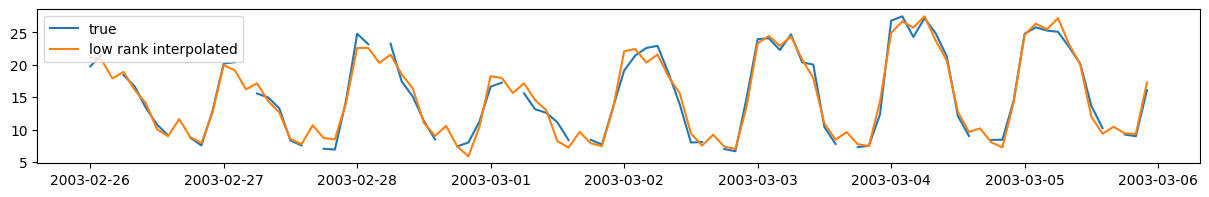

In [17]:
plt.figure(figsize=(15, 2))
plt.plot(df_siberia_equilibrate_2hourly['2003-02-26':'2003-03-05'], label='true')
plt.plot(train['2003-02-26':'2003-03-05'], label='low rank interpolated')
plt.legend()

### SARIMA

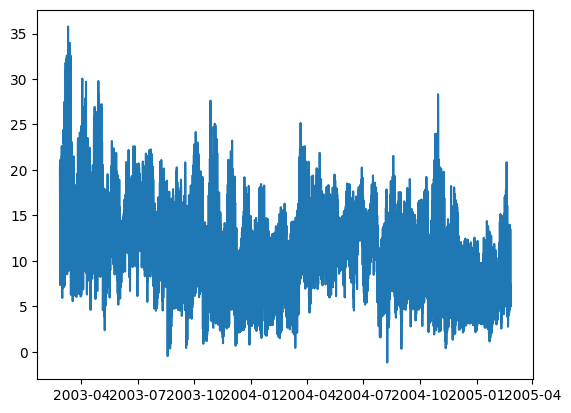

In [18]:
plt.plot( train [(train.index >= '2003-01-01') & (train.index < '2006-01-01')] )

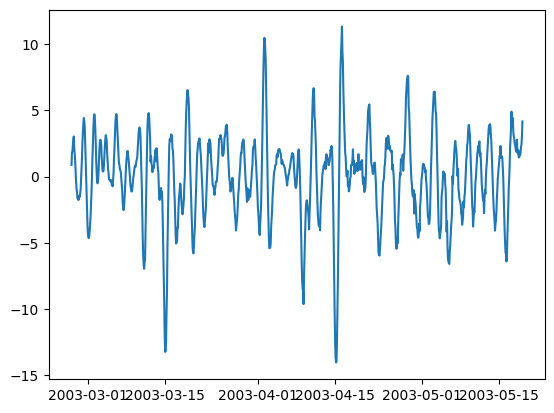

In [19]:
plt.plot(train.diff(12).iloc[:1000])

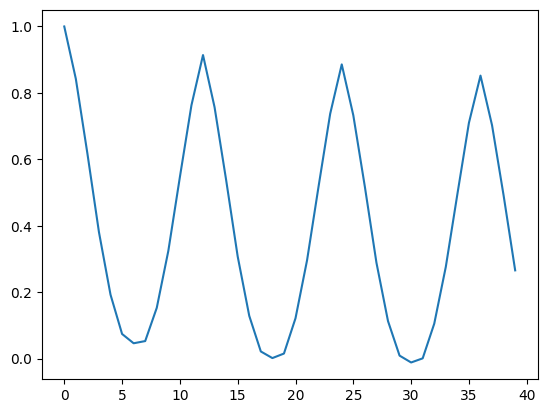

In [20]:
plt.plot(range(40), acf(train))

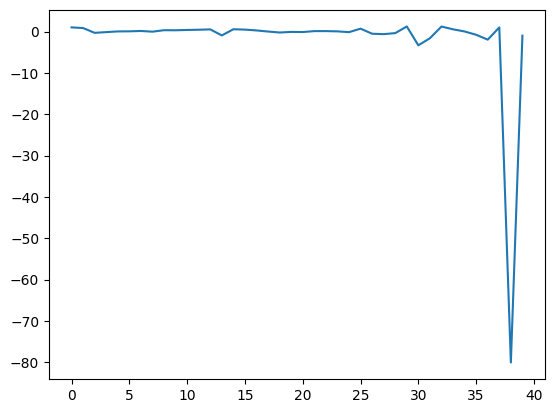

In [21]:
plt.plot(range(40), pacf(train))

In [22]:
adfuller(train, autolag='AIC')[1]

np.float64(0.00015264159671095774)

In [23]:
kpss(train.dropna())[1]

np.float64(0.01)

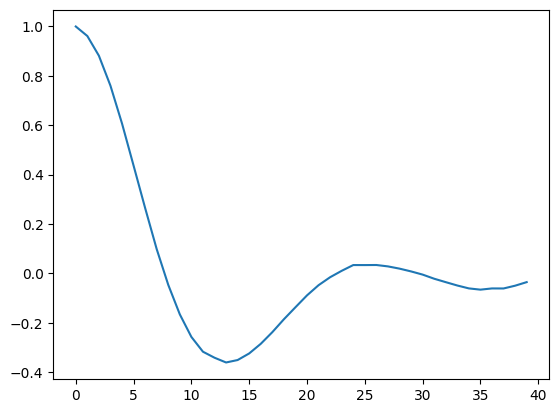

In [24]:
plt.plot(range(40), acf(train.diff(12).dropna()))

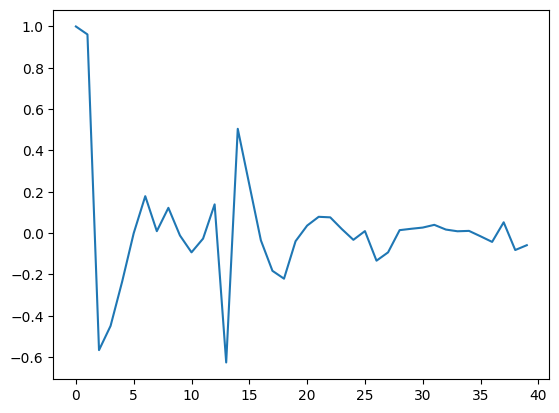

In [25]:
plt.plot(range(40), pacf(train.diff(12).dropna()))

In [26]:
# le test kpss de stationarité est rejeté pour la série sans aucune différenciation. De plus, il y a clairement de la saisonalité

In [27]:
adfuller(train.diff(12).dropna(), autolag='AIC')[1]

np.float64(1.057050916764623e-29)

In [28]:
kpss(train.diff(12).dropna())[1]

np.float64(0.1)

In [29]:
# on rejette l'hypothèse de racine unitaire après avoir différencié à l'ordre 12 -> la série est stationnaire

In [30]:
# le problème du SARIMAX est que l'on prend seulement la saisonnalité au niveau du jour, donc les prédictions ne dépendent que du jour précédent
# on ne peut pas prendre en compte la tendance à la hausse au début de l'année et à la baisse à la fin de l'année

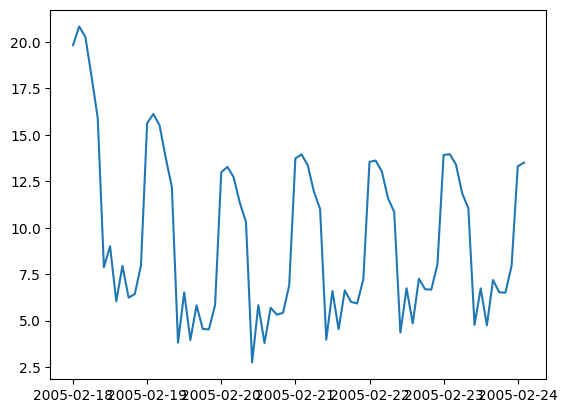

In [32]:
plt.plot(train.iloc[-84:-10])

In [33]:
# Fit model with best parameters, d=0 and D=1
best_model = SARIMAX(train.iloc[:-10], order=(2, 0, 2), seasonal_order=(2, 1, 2, 12)).fit(maxiter=100) # on n'entraîne que jusqu'à :-6 car c'est au milieu de la journée, sinon on va partir d'un pic et ça va avoir un impact sur toute la série
print("\nBest model summary:")
print(best_model.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17077D-01    |proj g|=  6.49570D-01

At iterate    5    f=  1.56626D-01    |proj g|=  1.37495D-01

At iterate   10    f=  1.25327D-01    |proj g|=  2.92271D-02

At iterate   15    f=  1.23007D-01    |proj g|=  3.00535D-01

At iterate   20    f=  1.15100D-01    |proj g|=  2.16740D-02

At iterate   25    f=  1.14785D-01    |proj g|=  2.14302D-03

At iterate   30    f=  1.14743D-01    |proj g|=  4.10756D-03

At iterate   35    f=  1.14562D-01    |proj g|=  8.94406D-03

At iterate   40    f=  1.13390D-01    |proj g|=  5.71371D-02

At iterate   45    f=  1.12409D-01    |proj g|=  2.91349D-02

At iterate   50    f=  1.12080D-01    |proj g|=  2.09690D-02

At iterate   55    f=  1.12015D-01    |proj g|=  1.10725D-02

At iterate   60    f=  1.11994D-01    |proj g|=  5.30527D-04

At iterate   65    f=  1.1

In [34]:
best_model.mle_retvals['converged']

True

In [35]:
predict = best_model.forecast(steps=5000)#, typ="level")
predict

2005-02-24 04:00:00    13.004273
2005-02-24 06:00:00    11.518683
2005-02-24 08:00:00    10.779262
2005-02-24 10:00:00     4.864569
2005-02-24 12:00:00     6.630412
                         ...    
2006-04-16 10:00:00     5.529616
2006-04-16 12:00:00     6.575071
2006-04-16 14:00:00     4.655202
2006-04-16 16:00:00     7.381732
2006-04-16 18:00:00     6.825845
Freq: 2h, Name: predicted_mean, Length: 5000, dtype: float64

In [36]:
train.mean()

tec    11.064834
dtype: float64

In [37]:
predict.mean()

np.float64(9.029857644805926)

In [38]:
test.mean()

tec    8.570384
dtype: float64

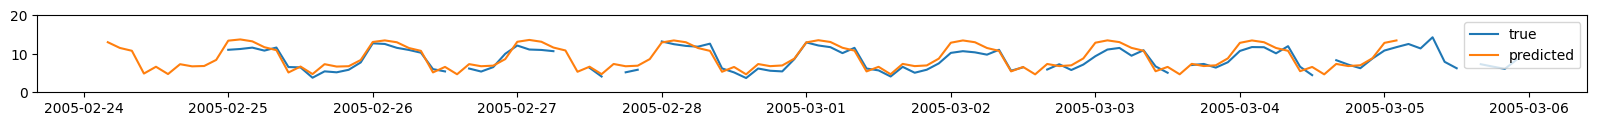

In [39]:
plt.figure(figsize=(20, 1))
plt.ylim(0, 20)
plt.plot(test, label='true')
plt.plot(predict.iloc[:108], label='predicted')
plt.legend()

In [40]:
# les prédictions ne sont pas valables sur du long terme car la saisonnalité n'est que journalière, donc ça répète la même journée à l'infini
# il faudrait prendre en compte la saisonnalité sur l'année aussi
# bizarrement, il semble que les prédictions sont très sensibles aux dernières observations : quand on utilise le train jusqu'à la fin on sous-estime alors qu'on surestime quand on utilise le train jusqu'au milieu de la dernière journée

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 6.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 8.000e+00,
        3.000e+00, 8.000e+00, 1.500e+01, 2.800e+01, 4.500e+01, 6.000e+01,
        1.090e+02, 1.450e+02, 2.600e+02, 4.780e+02, 8.370e+02, 1.310e+03,
        1.698e+03, 1.482e+03, 9.440e+02, 5.400e+02, 2.920e+02, 1.600e+02,
        9.000e+01, 5.300e+01, 3.900e+01, 3.600e+01, 2.200e+01, 1.800e+01,
        7.000e+00, 4.000e+00, 7.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-2.16447814, -2.07648142, -1.98848469, -1.90048796, -1.81249123,
        -1.7244945 , -1.63649777, -1.54850104, -1.46050431, -1.37250758,
        -1.28451085, -1.19651412, -1.10851739, -1.02052066, -0.93252393,
        -0.8445272 , -0.75653048, -0.66853375, -0.58053702, -0.49254029,
        -0.40454356, -0.31654683, -0.2285501 , -0.14055337, -0.05255664,
         0.

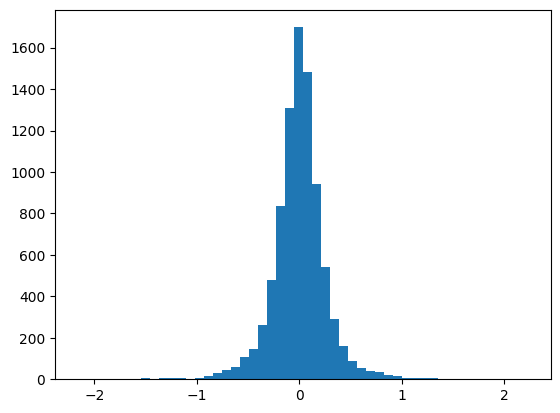

In [41]:
plt.hist(best_model.resid[20:], bins=50)

### LSTM

In [13]:
sequence_length = 50
test2 = test2[len(test2) - len(test) - sequence_length:]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train)

sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [38]:
num_lstm_layers = 2
dropout_rate = 0.2
batch_size = 48
epochs = 500
validation_split = 0.05
input_dim = 1
output_dim = 1

model = Sequential()

model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(units=output_dim, activation='linear'))

model.compile(optimizer='Adam', loss='mae', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1
)

2024-12-23 10:08:51.006876: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0839 - mae: 0.0839 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 2/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 3/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0589 - mae: 0.0589 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 4/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0574 - mae: 0.0574 - val_loss: 0.0437 - val_mae: 0.0437
Epoch 5/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0599 - mae: 0.0599 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 6/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0605 - mae: 0.0605 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 7/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0584 - mae: 0.0584 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 8/500
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0560 - mae: 0.0560 - val_loss: 0.0494 - val_mae: 0.0494
Epoch 9/500
173/173 ━━━━━━━━━━━━━━━━━━━

In [62]:
model.save('lstm/lstm_model.keras')

In [35]:
lstm_model = load_model('lstm/lstm_model.keras')

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(test2)

sequence_length = 50
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])

X_test = np.array(X_test)
y_test = np.array(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1391 - mae: 0.1391
Loss on test data: 0.14032581448554993
MAE on test data: 0.14032581448554993


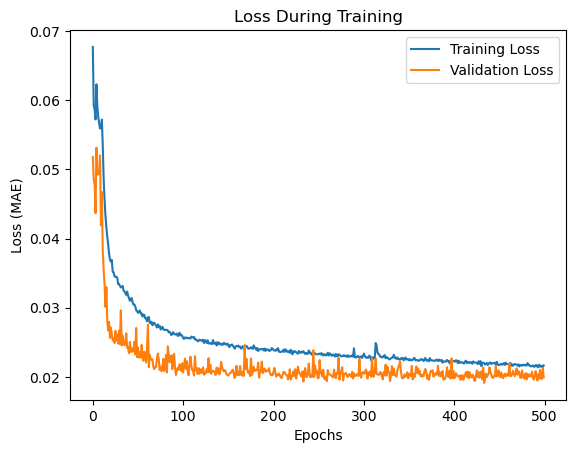

In [116]:
# Visualisation sur le dataset de test
loss, mae = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f"Loss on test data: {loss}")
print(f"MAE on test data: {mae}")

# Visualisation de l'apprentissage
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


RMSE of the LSTM model 6.7817073
Correlation of the LSTM model 0.77553884890125


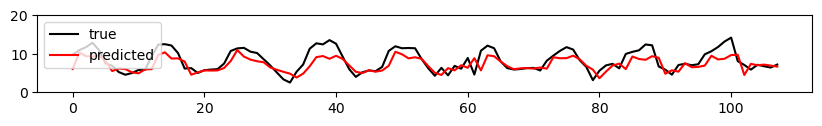

In [57]:
unscaled_lstm_prediction = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(unscaled_lstm_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(lstm_predictions, label='predicted', color='red')
plt.legend()

lstm_rmse = np.sqrt(np.mean(unscaled_seq_prediction - lstm_predictions)**2)
print('RMSE of the LSTM model', lstm_rmse)

lstm_correlation = correlation(lstm_predictions, unscaled_y_test)
print('Correlation of the LSTM model', lstm_correlation)

### Seq2Seq

In [ ]:
learning_rate = 0.01
lambda_l2_reg = 0.003
hidden_dim = 64
num_lstm_layers = 1  
gradient_clipping = 2.5
num_input_signals = 1
num_output_signals = 1

model = Sequential()

model.add(LSTM(
    units=hidden_dim, 
    activation='relu', 
    input_shape=(X_train.shape[1], num_input_signals), 
    return_sequences=False, 
    kernel_regularizer=tf.keras.regularizers.l2(lambda_l2_reg)
))

model.add(Dense(units=num_output_signals))

optimizer = Adam(learning_rate=learning_rate, clipvalue=gradient_clipping)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

model.summary()

history = model.fit(
    X_train, y_train,
    epochs=1500,
    batch_size=48,
    validation_split=0.2,
    verbose=1,
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0094 - mae: 0.0697 - val_loss: 0.0079 - val_mae: 0.0747
Epoch 2/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0057 - mae: 0.0571 - val_loss: 0.0055 - val_mae: 0.0618
Epoch 3/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0050 - mae: 0.0539 - val_loss: 0.0036 - val_mae: 0.0435
Epoch 4/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0037 - mae: 0.0424 - val_loss: 0.0060 - val_mae: 0.0637
Epoch 5/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0027 - mae: 0.0358 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 6/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0025 - mae: 0.0354 - val_loss: 0.0017 - val_mae: 0.0292
Epoch 7/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 8/1500
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0020 - val_mae: 0.0326
Epoch 9/1500
146/146 ━━━━━━━━━━━

In [ ]:
model.save('seq2seq/seq2seq_model.keras')

In [27]:
seq2seq_model = load_model('seq2seq/seq2seq_model.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE of the Seq2seq model 7.5917516
Correlation of the Seq2seq model 0.859081610584248


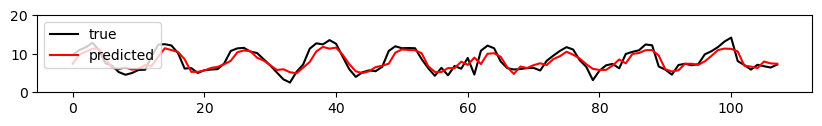

In [55]:
unscaled_seq_prediction = seq2seq_model.predict(X_test)
seq2seq_predictions = scaler.inverse_transform(unscaled_seq_prediction)

unscaled_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
plt.figure(figsize=(10, 1))
plt.ylim(0, 20)
plt.plot(unscaled_y_test, label='true', color='black')
plt.plot(seq2seq_predictions, label='predicted', color='red')
plt.legend()

seq_rmse = np.sqrt(np.mean(unscaled_seq_prediction - seq2seq_predictions)**2)
print('RMSE of the Seq2seq model', seq_rmse)

seq_correlation = correlation(seq2seq_predictions, unscaled_y_test)
print('Correlation of the Seq2seq model', seq_correlation)